In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['seg_train', 'seg_pred', 'seg_test']


In [2]:
!ls ../input

seg_pred  seg_test  seg_train


In [3]:
import torch
from torch import nn
from torchvision import datasets, models, transforms


In [4]:
import torch.utils.data as tdata

In [5]:
!ls ../input/seg_train/seg_train/
!ls ../input/seg_test/seg_test/

buildings  forest  glacier  mountain  sea  street
buildings  forest  glacier  mountain  sea  street


In [6]:
data_path_format = '../input/seg_{0}/seg_{0}'

In [7]:
np.random.seed(5315)
torch.manual_seed(9784)

In [8]:
# channel_means = (0.4301, 0.4572, 0.4540)
# channel_stds = (0.2698, 0.2680, 0.2983)  # 0.485, 0.456, 0.406
channel_means = (0.485, 0.456, 0.406)
channel_stds = (0.229, 0.224, 0.225)

In [9]:
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])
    

In [10]:
image_datasets = dict(zip(('dev', 'test'), [datasets.ImageFolder(data_path_format.format(key),transform=image_transforms) for key in ['train', 'test']]))
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None}


In [11]:
devset_indices = np.arange(len(image_datasets['dev']))
devset_labels = image_datasets['dev'].targets

In [12]:
from sklearn import model_selection

In [13]:
train_indices, val_indices, train_labels,  val_labels = model_selection.train_test_split(devset_indices, devset_labels, test_size=0.1, stratify=devset_labels)

In [14]:
print(len(val_indices))

1404


In [15]:
image_datasets['train'] = tdata.Subset(image_datasets['dev'], train_indices)
image_datasets['validation'] = tdata.Subset(image_datasets['dev'], val_indices)

In [16]:
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'train': <torch.utils.data.dataset.Subset object at 0x7f7a4a3de0f0>, 'validation': <torch.utils.data.dataset.Subset object at 0x7f7a4a3de0b8>}


In [17]:
from IPython.display import display

In [18]:
image_dataloaders = {key: tdata.DataLoader(image_datasets[key], batch_size=16,shuffle=True) for key in  ['train', 'validation']}

In [19]:
image_dataloaders['test'] = tdata.DataLoader(image_datasets['test'], batch_size=32)

In [20]:
def imshow(inp, title=None, fig_size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # C x H x W  # H x W x C
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot('111')
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_aspect('equal')
    plt.pause(0.001)  

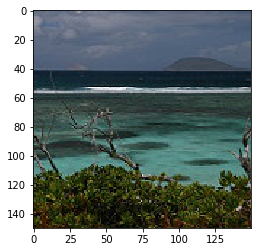

In [21]:
imshow(image_datasets['train'][8555][0]) # 5946

In [22]:
cuda_device = torch.device('cuda')
cpu_device = torch.device('cpu')
device = cuda_device

In [23]:
class task5Net(torch.nn.Module):
    
    #Отдельные методы класса для инициализации слоёв
    def layer(self, input_, output_, kernel_size):   
        return nn.Sequential(torch.nn.Conv2d(input_, output_, kernel_size, padding=1), 
                             torch.nn.ReLU(), 
                             torch.nn.BatchNorm2d(output_), 
                             torch.nn.MaxPool2d(2, 2))
    
    def layer_lin(self, input_, output_):
        return nn.Sequential(torch.nn.Linear(input_, output_))
    
    def __init__(self):
        
        super(task5Net, self).__init__()
        
        #Начальные параметры входа и выхода
        input_ = 3  #RGB
        output_ = 10
        
        end_lin = 6  #Количество классов для распознавания
        
        #Размер перемещающейся по изображению свёртки (3x3)
        kernel_size = 3
        
        #Инициализация слоёв
        self.layer1 = self.layer(input_, 10, kernel_size)

        self.layer2 = self.layer(10, 20, kernel_size)
        
        self.layer3 = self.layer(20, 40, kernel_size)

        self.layer4 = self.layer(40, 80, kernel_size)

        self.layer5 = self.layer(80, 160, kernel_size)
        
        self.layer6 = self.layer(160, 320, kernel_size)
    
        #Линейные преобразования
        self.fc1 = self.layer_lin(1280, 80)
        
        self.fc2 = self.layer_lin(80, 20)
        
        self.fc3 = self.layer_lin(20, end_lin)
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x) 
        x = self.layer5(x) 
        x = self.layer6(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x
    
ptr = task5Net()
ptr = ptr.to(device)

print(task5Net())

task5Net(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()


In [24]:
class BestModel:
    def __init__(self, path, initial_criterion):
        self.path = path
        self.criterion = initial_criterion
        
    def update(self, model, optimizer, criterion):
        self.criterion = criterion
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'criterion': criterion}, self.path)
        
    def load_model_data(self):
        return torch.load(self.path)
    
    def restore(self, model, optimizer):
        model_data = self.load_model_data()
        model.load_state_dict(model_data['model_state'])
        optimizer.load_state_dict(model_data['optimizer_state'])

In [25]:
def train_model(epochs, model, optimizer, criterion, loaders, device, best_model, n_prints=1):
    print_every = len(loaders['train']) // n_prints
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for iteration, (xx, yy) in enumerate(loaders['train']):
            optimizer.zero_grad()
            xx, yy = xx.to(device), yy.to(device)
            out = model(xx)
            loss = criterion(out, yy)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if(iteration % print_every == print_every - 1):
                running_train_loss /= print_every
                print(f"Epoch {epoch}, iteration {iteration} training_loss {running_train_loss}")
                running_train_loss = 0.0
            
        with torch.no_grad():
            model.eval()
            running_corrects = 0
            running_total = 0
            running_loss = 0.0
            for xx, yy in loaders['validation']:
                batch_size = xx.size(0)
                xx, yy = xx.to(device), yy.to(device)

                out = model(xx)
                
                loss = criterion(out, yy)
                running_loss += loss.item()
                
                predictions = out.argmax(1)
                running_corrects += (predictions == yy).sum().item()
                running_total += batch_size
            
            mean_val_loss = running_loss / len(loaders['validation'])
            accuracy = running_corrects / running_total
            
            if accuracy > best_model.criterion:
                best_model.update(model, optimizer, accuracy)
            
            print(f"Epoch {epoch}, val_loss {mean_val_loss}, accuracy = {accuracy}")
    best_model.restore(model, optimizer)
                
                

In [26]:
import time
start = time.time()

In [27]:
optimizer = torch.optim.Adam(ptr.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
best_model = BestModel('resnet_data',0.0)
train_model(10, ptr, optimizer, criterion,image_dataloaders, device, best_model=best_model, n_prints=5)

Epoch 0, iteration 157 training_loss 1.0462504283914082
Epoch 0, iteration 315 training_loss 0.7760714183125315
Epoch 0, iteration 473 training_loss 0.7029514544749562
Epoch 0, iteration 631 training_loss 0.6477268660747553
Epoch 0, iteration 789 training_loss 0.611551623932923
Epoch 0, val_loss 0.5801481978798454, accuracy = 0.7806267806267806
Epoch 1, iteration 157 training_loss 0.5357867527423026
Epoch 1, iteration 315 training_loss 0.5238722395859187
Epoch 1, iteration 473 training_loss 0.5552172231711919
Epoch 1, iteration 631 training_loss 0.5170648143261294
Epoch 1, iteration 789 training_loss 0.5013584106028834
Epoch 1, val_loss 0.5150843205099757, accuracy = 0.801994301994302
Epoch 2, iteration 157 training_loss 0.43966308834997914
Epoch 2, iteration 315 training_loss 0.4255508569694018
Epoch 2, iteration 473 training_loss 0.430512304641778
Epoch 2, iteration 631 training_loss 0.44108769778586643
Epoch 2, iteration 789 training_loss 0.4208243707595747
Epoch 2, val_loss 0.41356

In [28]:
end = time.time()
print(end - start)

495.79895973205566


In [29]:
from torchvision.utils import make_grid

In [30]:
xx, yy = next(iter(image_dataloaders['validation']))

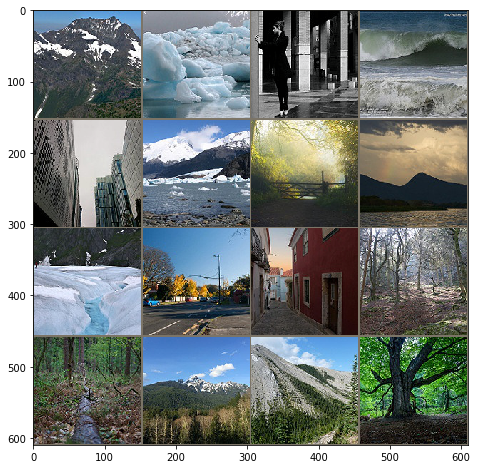

['glacier', 'glacier', 'street', 'sea', 'buildings', 'glacier', 'forest', 'sea', 'glacier', 'street', 'street', 'forest', 'forest', 'mountain', 'glacier', 'forest']
['mountain', 'glacier', 'street', 'sea', 'buildings', 'glacier', 'forest', 'mountain', 'glacier', 'street', 'street', 'forest', 'forest', 'mountain', 'mountain', 'forest']


In [31]:
ptr.eval()
out = ptr(xx.cuda())
preds = out.argmax(1)
predicted_classes = [image_datasets['dev'].classes[c] for c in preds]
actual_classes = [image_datasets['dev'].classes[c] for c in yy]
imshow(make_grid(xx, nrow=4), fig_size=(8,8))
print(predicted_classes)
print(actual_classes)

In [32]:
all_preds = []
correct_preds = []
with torch.no_grad():
    ptr.eval()
    for xx, yy in image_dataloaders['test']:
        xx = xx.to(device)
        output = ptr(xx)
        all_preds.extend(output.argmax(1).tolist())
        correct_preds.extend(yy.tolist())

In [33]:
from sklearn import metrics

In [34]:
all_preds = np.asarray(all_preds)
correct_preds = np.asarray(correct_preds)

In [35]:
target_names = image_datasets['test'].classes
print(metrics.classification_report(correct_preds, all_preds,target_names=target_names))

              precision    recall  f1-score   support

   buildings       0.90      0.74      0.81       437
      forest       0.93      0.96      0.94       474
     glacier       0.81      0.72      0.76       553
    mountain       0.80      0.78      0.79       525
         sea       0.78      0.92      0.84       510
      street       0.83      0.90      0.87       501

   micro avg       0.84      0.84      0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



In [36]:
confusion_matrix = metrics.confusion_matrix(correct_preds, all_preds)
pd.DataFrame(confusion_matrix, index=target_names, columns=target_names)

,buildings,forest,glacier,mountain,sea,street
buildings,325,13,11,9,13,66
forest,5,455,2,4,5,3
glacier,3,2,400,68,69,11
mountain,0,6,64,412,37,6
sea,5,2,16,15,467,5
street,25,11,2,4,6,453
